In [5]:
import os, re, json
import numpy as np


In [2]:
# change to the root folder
base_dir = "/Users/jibanmac/Documents/GitHub/gpy_dla_detection/"
os.chdir(base_dir)

try:
    assert "null_gp.py" in os.listdir("gpy_dla_detection")
except Exception as e:
    print(e)
    print(
        "[Warning] Change the directory of base_dir to the path of your gpy_dla_detection repository."
    )

In [3]:
# plotting styles
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

mpl.rcParams['figure.dpi'] = 150

In [12]:
# The test selection file includes a list of 100 quasar spectra and their redshifts
from tests import test_selection

# The module to read spectrum, which also helps us to download the file (for SDSS DR12 spectrum)
from gpy_dla_detection.read_spec import read_spec, retrieve_raw_spec


In [4]:
# My current favourite style
import arviz as az

az.style.use("arviz-viridish")


# Making a cover photo for the DLA project

Let's make a plot with several spectra with detected DLAs, raning from low-z (z=2.5) to
high-z (z=6).
Colour-coded each spectrum with redshift - high-z with red color and low-z with blue color.

First thing, need to download the DLA catalog - Let's use the DR12 catalog.


In [6]:
with open(
    "data/dla_catalogs/dr12q_gp/predictions_multi_DLAs_lyseries_a03.json", "r"
) as f:
    dr12q_catalog = json.load(f)


View the data format:


In [7]:
dr12q_catalog[0]

{'p_dla': 3.266889715172513e-06,
 'p_no_dla': 0.9999967331102849,
 'max_model_posterior': 0.9999967331102849,
 'num_dlas': 0,
 'min_z_dla': 1.9654068693822793,
 'max_z_dla': 2.298898241719346,
 'snr': 4.20216439540205,
 'ra': 0.001898285183756343,
 'dec': 17.773739129913793,
 'plate': 6173,
 'mjd': 56238,
 'fiber_id': 528,
 'thing_id': 268514930,
 'z_qso': 2.3090972900390625,
 'dlas': []}

There are some criteria I want:

- SNR > 8
- p_dla > 0.9


In [41]:
real_index = np.where(
    [(spec["p_dla"] > 0.9 and spec["snr"] > 8) for spec in dr12q_catalog]
)[0]
real_index

array([    15,     33,     51, ..., 158805, 158811, 158824])

Now, test if I can read the spectrum and plot the detection:


In [43]:
def download_and_read(
    plate: int,
    mjd: int,
    fiber_id: int,
):
    filename = "spec-{:d}-{:d}-{:04d}.fits".format(plate, mjd, fiber_id)

    # If we haven't downloaded the file, this cell will help you download the file from SDSS database
    if not os.path.exists(filename):
        # This line gets the plate, mjd, and fiber_id from the given filename
        # Note: re is the regex.
        plate, mjd, fiber_id = re.findall(
            r"spec-([0-9]+)-([0-9]+)-([0-9]+).fits",
            filename,
        )[0]
        # Download the file using the given plate, mjd, and fiber_id
        retrieve_raw_spec(int(plate), int(mjd), int(fiber_id))

    # make sure the file exists
    assert os.path.exists(filename) == True

    # Read the raw spectrum: This line reads the spectrum file into four numpy arrays
    wavelengths, flux, noise_variance, pixel_mask = read_spec(filename)
    # simulated data
    # you have : wavelengths (velocities), flux
    # noise_variance : you need to inject your own noise
    # pixel_mask : you don't have. pixel_mask is the invalid pixel in spectrum
    return wavelengths, flux, noise_variance, pixel_mask


Let's try to read the first one:


In [44]:
ith = 0

spec_dict = dr12q_catalog[real_index[ith]]

# extract info
plate = spec_dict["plate"]
mjd = spec_dict["mjd"]
fiber_id = spec_dict["fiber_id"]

z_qso = spec_dict["z_qso"]

# dla detection
dlas_dict = spec_dict["dlas"]
num_dlas = len(dlas_dict)
z_dlas = []
log_nhis = []
for j in range(num_dlas):
    z_dlas.append(dlas_dict[j]["z_dla"])
    log_nhis.append(dlas_dict[j]["log_nhi"])

spec_dict


{'p_dla': 0.9999986904566132,
 'p_no_dla': 1.3095433867930426e-06,
 'max_model_posterior': 0.9997338757336238,
 'num_dlas': 1,
 'min_z_dla': 1.930113072783267,
 'max_z_dla': 2.704355744830682,
 'snr': 9.110750106843343,
 'ra': 0.02128021280228154,
 'dec': -10.813916416894397,
 'plate': 7167,
 'mjd': 56604,
 'fiber_id': 290,
 'thing_id': 21077479,
 'z_qso': 2.7146546840667725,
 'dlas': [{'log_nhi': 20.940101637050827, 'z_dla': 2.4821106711832828}]}

In [45]:
wavelengths, flux, noise_variance, pixel_mask = download_and_read(plate, mjd, fiber_id)


(-1.0, 5.0)

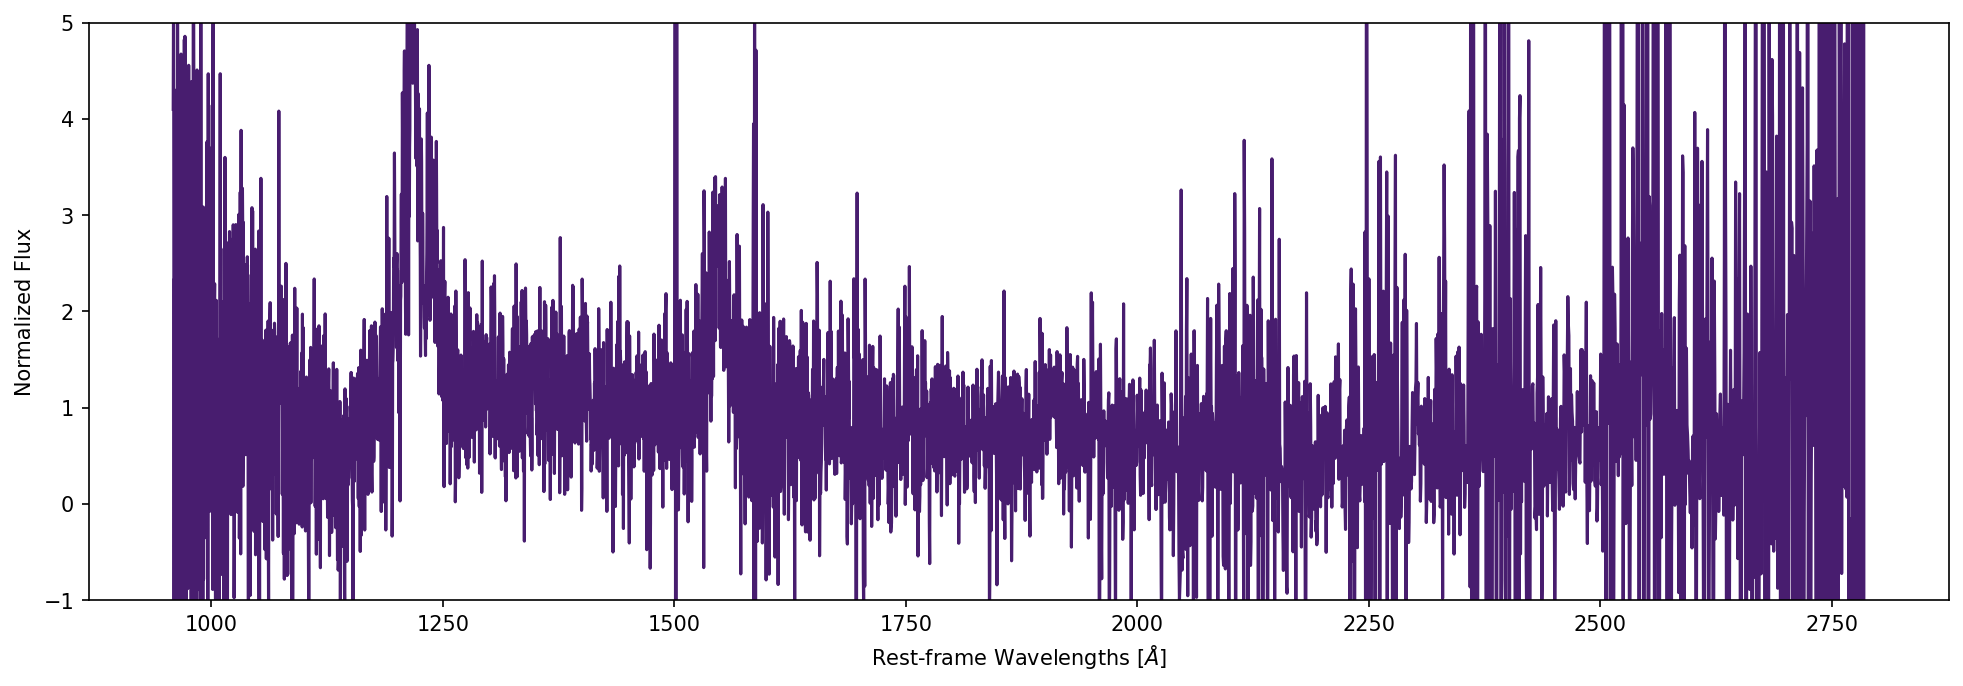

In [46]:
rest_wavelengths = wavelengths / (1 + z_qso)

plt.figure(figsize=(16, 5))
# I did a normalization in this step to make the plot esier to see
plt.plot(rest_wavelengths, flux / np.mean(flux))
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-1, 5)

## Create the Bayesian model


In [21]:
from gpy_dla_detection.set_parameters import Parameters

# Note: these parameters are used during training. Change these parameters here won't change your
# trained GP model unless you re-train your GP model.
param = Parameters(
    loading_min_lambda=800,  # range of rest wavelengths to load  Å
    loading_max_lambda=1550,
    # normalization parameters
    normalization_min_lambda=1425,  # range of rest wavelengths to use   Å
    normalization_max_lambda=1475,  #   for flux normalization
    # null model parameters
    min_lambda=850.75,  # range of rest wavelengths to       Å
    max_lambda=1420.75,  #   model
    dlambda=0.25,  # separation of wavelength grid      Å
    k=20,  # rank of non-diagonal contribution
    max_noise_variance=3**2,  # maximum pixel noise allowed during model training
)

# BOSS DR12 effective optical depth
param.tau_0_mu = 0.00554  # meanflux suppression for τ₀
param.tau_0_sigma = 0.00064  # meanflux suppression for τ₀
param.beta_mu = 3.182  # meanflux suppression for β
param.beta_sigma = 0.074  # meanflux suppression for β

param

{'loading_min_lambda': 800, 'loading_max_lambda': 1550, 'z_qso_cut': 2.15, 'min_num_pixels': 200, 'normalization_min_lambda': 1425, 'normalization_max_lambda': 1475, 'min_lambda': 850.75, 'max_lambda': 1420.75, 'dlambda': 0.25, 'k': 20, 'max_noise_variance': 9, 'initial_c_0': 0.1, 'initial_tau_0': 0.0023, 'initial_beta': 3.65, 'minFunc_options': {'MaxIter': 2000, 'MaxFunEvals': 4000}, 'num_dla_samples': 10000, 'alpha': 0.97, 'uniform_min_log_nhi': 20.0, 'uniform_max_log_nhi': 23.0, 'fit_min_log_nhi': 20.0, 'fit_max_log_nhi': 22.0, 'prior_z_qso_increase': 0.10006922855944561, 'width': 3, 'pixel_spacing': 0.0001, 'num_lines': 3, 'max_z_cut': 0.010006922855944561, 'min_z_cut': 0.010006922855944561, 'num_forest_lines': 31, 'tau_0_mu': 0.00554, 'tau_0_sigma': 0.00064, 'beta_mu': 3.182, 'beta_sigma': 0.074}

In [22]:
from gpy_dla_detection.model_priors import PriorCatalog

# Note: you need to follow the README to download these files!
prior = PriorCatalog(
    param,
    "data/dr12q/processed/catalog.mat",
    "data/dla_catalogs/dr9q_concordance/processed/los_catalog",
    "data/dla_catalogs/dr9q_concordance/processed/dla_catalog",
)
prior


In [23]:
from gpy_dla_detection.null_gp import NullGP
from gpy_dla_detection.dla_gp import DLAGP

# Use h5py to read the learned GP model
import h5py


# Null model GP : a GP model without any DLA intervening.
# Note that it's model without DLAs, so the noise term might still include some
# LLS or subDLAs
class NullGPDR12(NullGP):
    """
    Load learned model from SDSS DR12 data without DLAs

    params: globla parameters used to train the model and some parameters define to priors of the model.
    prior: the prior catalog based on SDSS DR9 Lya catalog (We haven't switch to DR12 DLA catalog, we could
        use Ho-Bird-Garnett 2020 catalog). You can change the definition of self.log_prior
        to overwrite the prior from prior catalog.
    learned_file: the input .MAT file for the learned GP model.
    prev_tau_0: tau_0 to change the meanflux of the GP mean function. The effective meanflux model is
        tau = tau_0 * exp( -(1 + z)^beta ). Details see gpy_dla_detection/effective_optical_depth.py
    prev_beta: beta to change the meanflux of thte GP mean function.
    """

    def __init__(
        self,
        params: Parameters,
        prior: PriorCatalog,
        learned_file: str = "learned_qso_model_lyseries_variance_kim_dr9q_minus_concordance.mat",
        prev_tau_0: float = 0.0023,
        prev_beta: float = 3.65,
    ):
        with h5py.File(learned_file, "r") as learned:
            rest_wavelengths = learned["rest_wavelengths"][:, 0]
            mu = learned["mu"][:, 0]
            M = learned["M"][()].T
            log_omega = learned["log_omega"][:, 0]
            log_c_0 = learned["log_c_0"][0, 0]
            log_tau_0 = learned["log_tau_0"][0, 0]
            log_beta = learned["log_beta"][0, 0]

        super().__init__(
            params,
            prior,
            rest_wavelengths,
            mu,
            M,
            log_omega,
            log_c_0,
            log_tau_0,
            log_beta,
            prev_tau_0=prev_tau_0,
            prev_beta=prev_beta,
        )


# get the instance of GP null model
gp = NullGPDR12(
    params=param,
    prior=prior,
    # you should put your downloaded file in this directory
    learned_file="data/dr12q/processed/learned_qso_model_lyseries_variance_wmu_boss_dr16q_minus_dr12q_gp_851-1421.mat",
    # SDSS/BOSS DR12 meanflux effective optical depth for Lyman alpha forest
    prev_tau_0=0.00554,  # suppression: tau
    prev_beta=3.182,  # suppression: beta
)

# Make the GP model interpolated onto the observed quasar spectum
gp.set_data(rest_wavelengths, flux, noise_variance, pixel_mask, z_qso, build_model=True)

Null model


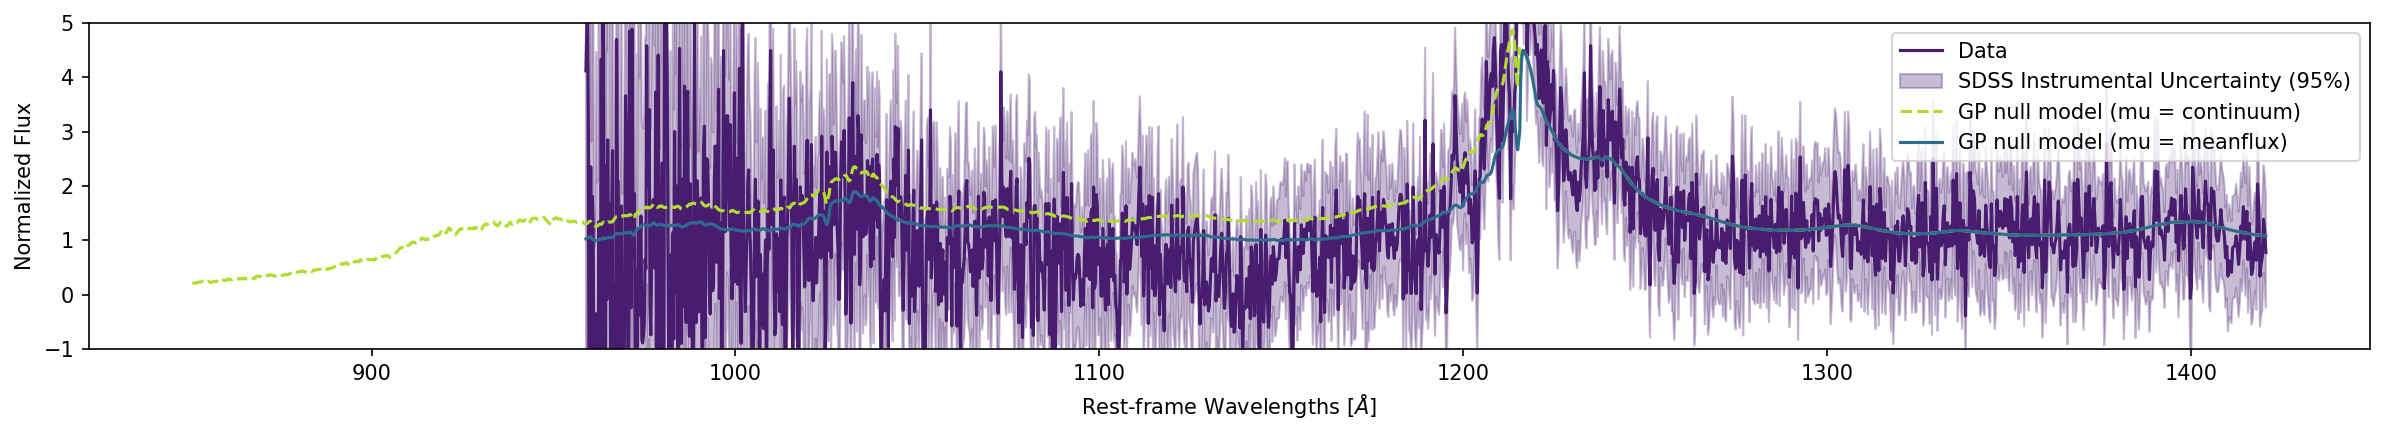

In [24]:
plt.figure(figsize=(16, 3))

# Mean function
plt.plot(
    gp.X,  # quasar spectrum's rest-frame wavelengths
    gp.Y,  # quasar spectrum's flux
    label="Data",
)
plt.fill_between(
    gp.X,
    gp.Y - 2 * np.sqrt(gp.v),
    gp.Y + 2 * np.sqrt(gp.v),
    label="SDSS Instrumental Uncertainty (95%)",
    color="C0",
    alpha=0.3,
)
plt.plot(
    gp.rest_wavelengths,
    gp.mu,
    label="GP null model (mu = continuum)",
    color="C3",
    ls="--",
)
plt.plot(
    gp.X, gp.this_mu, label="GP null model (mu = meanflux)"  # GP model's mean function
)
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.legend(loc="upper right")
plt.ylim(-1, 5)
plt.tight_layout()
plt.savefig("poster-plot.png", format="png", dpi=300, transparent=True)

DLA model


In [25]:
from gpy_dla_detection.dla_gp import DLAGP
from gpy_dla_detection.dla_samples import DLASamplesMAT


# Strong Lyman Alpha model GP : a GP model with at least one strong Lyman alpha absorption.
class LyaGPDR12(DLAGP):
    """
    Load learned model from SDSS DR12 data without DLAs, and parameterize the Voigt profile + include
    the parameter priors (NHI, zLya) for sampling the Voigt profile

    Parameters:
    ---
    lya_samples: the Monte Carlo samples of the prior (NHI, zLya) you will be using to search for the
        strong Lya absorbers.

    params: globla parameters used to train the model and some parameters define to priors of the model.
    prior: the prior catalog based on SDSS DR9 Lya catalog. You can change the definition of self.log_prior
        to overwrite the prior from prior catalog.
    learned_file: the input .MAT file for the learned GP model.
    prev_tau_0: tau_0 to change the meanflux of the GP mean function. The effective meanflux model is
        tau = tau_0 * exp( -(1 + z)^beta ). Details see gpy_dla_detection/effective_optical_depth.py
    prev_beta: beta to change the meanflux of thte GP mean function.
    """

    def __init__(
        self,
        params: Parameters,
        prior: PriorCatalog,
        lya_samples: DLASamplesMAT,
        learned_file: str = "learned_qso_model_lyseries_variance_kim_dr9q_minus_concordance.mat",
        prev_tau_0: float = 0.0023,
        prev_beta: float = 3.65,
        min_z_separation: float = 3000.0,  # km/s
        broadening: bool = True,
    ):
        with h5py.File(learned_file, "r") as learned:
            rest_wavelengths = learned["rest_wavelengths"][:, 0]
            mu = learned["mu"][:, 0]
            M = learned["M"][()].T
            log_omega = learned["log_omega"][:, 0]
            log_c_0 = learned["log_c_0"][0, 0]
            log_tau_0 = learned["log_tau_0"][0, 0]
            log_beta = learned["log_beta"][0, 0]

        super().__init__(
            params,
            prior,
            lya_samples,
            rest_wavelengths,
            mu,
            M,
            log_omega,
            log_c_0,
            log_tau_0,
            log_beta,
            prev_tau_0=prev_tau_0,
            prev_beta=prev_beta,
            min_z_separation=min_z_separation,
            broadening=broadening,
        )

In [ ]:
from scipy.integrate import (
    quad,
)  # to get the normalization constant for the probability density function
from scipy.stats.qmc import Halton
from scipy.interpolate import interp1d


Sum of the PDF:


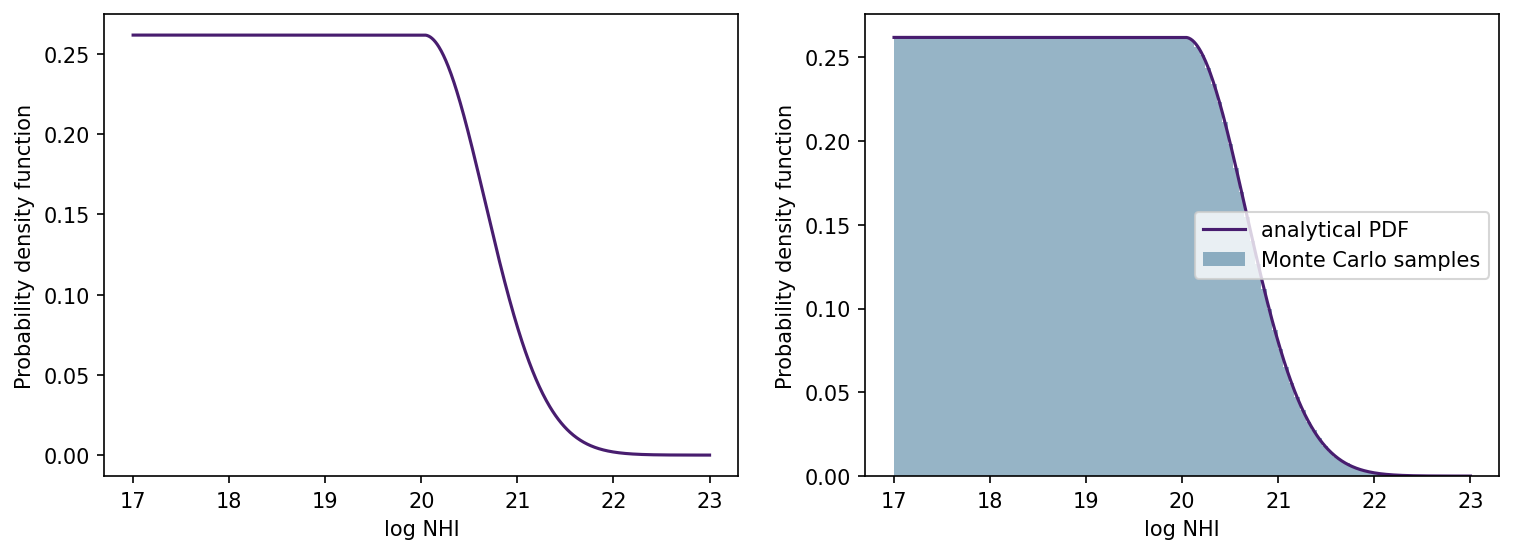

In [34]:
# directly use the fitted poly values in the Garnett (2017)
unnormalized_dla_pdf = lambda log_nhi: (
    np.exp(-1.2695 * log_nhi**2 + 50.863 * log_nhi - 509.33)
)
# add a flat prior at the low column density end
unnormalized_pdf = lambda log_nhi: (
    unnormalized_dla_pdf(log_nhi) * (log_nhi >= 20.03)
    + unnormalized_dla_pdf(20.03)
    * (
        log_nhi < 20.03
    )  # This part, you can get the prior from large simulations. But now is uniform
)

Z = quad(unnormalized_pdf, 17, 23.0)[0]

normalized_pdf = lambda log_nhi: unnormalized_pdf(log_nhi) / Z


log_nhis = np.linspace(17, 23, num=1000)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(log_nhis, normalized_pdf(log_nhis))
ax[0].set_xlabel("log NHI")
ax[0].set_ylabel("Probability density function")

# Make sure the probability density is summed to one
print("Sum of the PDF:")
np.sum(normalized_pdf(log_nhis) * (log_nhis[1] - log_nhis[0]))


# We want Monte Carlo samples - here to use Halton sequence to speed up the convergence
sampler = Halton(
    d=2,  # dimension of parameter space
    scramble=True,
)

num_samples = 50000
halton_sequence = sampler.random(num_samples)


# Inver transform sampling
# https://en.wikipedia.org/wiki/Inverse_transform_sampling
# code ref:
# https://gist.github.com/amarvutha/c2a3ea9d42d238551c694480019a6ce1
def sample(g, min_lognhi=17, max_lognhi=23):
    x = np.linspace(
        min_lognhi,
        max_lognhi,
        num=int(1e8),  # if you see interpolation error, increase this number
    )
    y = g(x)  # probability density function, pdf
    cdf_y = np.cumsum(y)  # cumulative distribution function, cdf
    cdf_y = cdf_y / cdf_y.max()  # takes care of normalizing cdf to 1.0
    inverse_cdf = interp1d(cdf_y, x)  # this is a function
    return inverse_cdf


def return_samples(halton_sequence: np.ndarray):
    required_samples = sample(normalized_pdf)(halton_sequence)
    return required_samples


samples_log_nhis = return_samples(
    halton_sequence[:, 0],
)

ax[1].plot(log_nhis, normalized_pdf(log_nhis), label="analytical PDF")
ax[1].set_xlabel("log NHI")
ax[1].set_ylabel("Probability density function")
ax[1].hist(
    samples_log_nhis, bins=100, density=True, alpha=0.5, label="Monte Carlo samples"
)

ax[1].legend()

In [35]:
from gpy_dla_detection.dla_samples import DLASamples


class LyaSamples(DLASamples):
    """
    Parameter prior (NHI, zLya) for strong Lya absorbers (logNHI = 17 - 23).

    This is a wrapper over the Monte Carlo samples already generated, so
    you should have already obtained the samples for the parameter prior
    somewhere else.

    We assume the same zLya prior as Garnett (2017):

        zLya ~ U(zmin, zmax)

        zmax = z_QSO - max_z_cut
        zmin = z_Ly∞ + min_z_cut
    """

    def __init__(
        self,
        params: Parameters,
        prior: PriorCatalog,
        offset_samples: np.ndarray,
        log_nhi_samples: np.ndarray,
        max_z_cut: float = 3000,  # km/s
        min_z_cut: float = 3000,  # km/s
    ):
        super().__init__(params, prior)

        self._offset_samples = offset_samples
        self._log_nhi_samples = log_nhi_samples
        self._nhi_samples = 10**log_nhi_samples

    @property
    def offset_samples(self) -> np.ndarray:
        return self._offset_samples

    @property
    def log_nhi_samples(self) -> np.ndarray:
        return self._log_nhi_samples

    @property
    def nhi_samples(self) -> np.ndarray:
        return self._nhi_samples

    def sample_z_dlas(self, wavelengths: np.ndarray, z_qso: float) -> np.ndarray:
        sample_z_dlas = (
            self.min_z_dla(wavelengths, z_qso)
            + (
                self.params.max_z_dla(wavelengths, z_qso)
                - self.min_z_dla(wavelengths, z_qso)
            )
            * self._offset_samples
        )

        return sample_z_dlas

    def min_z_dla(self, wavelengths: np.ndarray, z_qso: float) -> float:
        """
        determines minimum z_DLA to search

        We only consider z_dla within the modelling range.
        """
        rest_wavelengths = self.params.emitted_wavelengths(wavelengths, z_qso)
        ind = (rest_wavelengths >= self.params.min_lambda) & (
            rest_wavelengths <= self.params.max_lambda
        )
        # Here change to Lyb minimum
        return np.max(
            [
                np.min(wavelengths[ind]) / self.params.lya_wavelength - 1,
                self.params.observed_wavelengths(self.params.lyb_wavelength, z_qso)
                / self.params.lya_wavelength
                - 1
                + self.params.min_z_cut,
            ]
        )

    def _build_pdf(self):
        """
        Benchmark PDF we used in Garnett (2017), without mixing with a uniform prior
        """
        # directly use the fitted poly values in the Garnett (2017)
        unnormalized_dla_pdf = lambda log_nhi: (
            np.exp(-1.2695 * log_nhi**2 + 50.863 * log_nhi - 509.33)
        )
        # add a flat prior at the low column density end
        unnormalized_pdf = lambda log_nhi: (
            unnormalized_dla_pdf(log_nhi) * (log_nhi >= 20.03)
            + unnormalized_dla_pdf(20.03) * (log_nhi < 20.03)
        )

        Z = quad(unnormalized_pdf, 17, 23.0)[0]

        self.normalized_pdf = lambda log_nhi: unnormalized_pdf(log_nhi) / Z

    def pdf(self, log_nhi: float) -> float:
        """
        The logNHI pdf used in Garnett (2017) paper.
        """
        return self.normalized_pdf(log_nhi)


In [36]:
# samples for the Monte Carlo integration to get the likelihood of an absorber
# p( D | absorber model ) = \int p( D | z_abs, NHI, absorber model) p(z_abs) p(NHI) d z_abs d NHI

# p(z_abs) p(NHI)
lya_samples = LyaSamples(
    params=param,
    prior=prior,
    # offset samples
    offset_samples=halton_sequence[:, 1],
    log_nhi_samples=samples_log_nhis,
    max_z_cut=3000,
    min_z_cut=3000,
)


In [37]:
# Lya Model GP : this is null model GP + Voigt profile, which is parameterised with
# {(z_lya, logNHI)}_{i=1}^{k} parameters. k stands for maximum Lya absorpbers we want to search.
# we will compute log posteriors for DLA(1), ..., DLA(k) models.

# I want the Voigt profile to use Lya series lines up to 31
param.num_lines = 3
param.num_dla_samples = len(samples_log_nhis)

lya_gp = LyaGPDR12(
    params=param,
    prior=prior,
    lya_samples=lya_samples,  # 1. you input the NHI zabs samples to integrate
    min_z_separation=2000,  # 2. you have the minimum zabs separateion, in unit of km/s
    learned_file="data/dr12q/processed/learned_qso_model_lyseries_variance_wmu_boss_dr16q_minus_dr12q_gp_851-1421.mat",
    broadening=True,
    prev_tau_0=0.00554,  # suppression: tau
    prev_beta=3.182,  # suppression: beta
)
lya_gp.set_data(
    rest_wavelengths,
    flux,
    noise_variance,
    pixel_mask,
    z_qso,
    build_model=True,
)

## An example plot


In [107]:
# sort based on zQSO
real_index = np.where(
    [
        (spec["p_dla"] > 0.99 and spec["snr"] > 12 and spec["z_qso"] < 5.8)
        for spec in dr12q_catalog
    ]
)[0]

real_index_zqso_sorted = np.argsort(
    [dr12q_catalog[index]["z_qso"] for index in real_index]
)
real_index_zqso_sorted[::-1]


array([3218, 1164, 6860, ..., 6576,  805, 1264])

In [108]:
# from blue to red
cmap = plt.get_cmap("Spectral_r")

{'p_dla': 0.9958512280658773, 'p_no_dla': 0.004148771934122618, 'max_model_posterior': 0.9958512219359222, 'num_dlas': 1, 'min_z_dla': 1.930113072783267, 'max_z_dla': 2.142704158913473, 'snr': 13.67585565103197, 'ra': 111.84249691562215, 'dec': 42.65063106178144, 'plate': 3659, 'mjd': 55181, 'fiber_id': 488, 'thing_id': 449332121, 'z_qso': 2.153, 'dlas': [{'log_nhi': 20.39679073742997, 'z_dla': 2.0551971835190574}]}
{'p_dla': 0.9999999999999267, 'p_no_dla': 7.33627274034438e-14, 'max_model_posterior': 0.9999999996470117, 'num_dlas': 1, 'min_z_dla': 1.9674555331581716, 'max_z_dla': 2.4214955753816887, 'snr': 15.356443186846672, 'ra': 204.64788692896565, 'dec': 47.619878233096735, 'plate': 6748, 'mjd': 56371, 'fiber_id': 868, 'thing_id': 476039317, 'z_qso': 2.4312891960144043, 'dlas': [{'log_nhi': 20.685424407870723, 'z_dla': 2.111338339507323}]}
{'p_dla': 0.9999859544445281, 'p_no_dla': 1.4045555471757067e-05, 'max_model_posterior': 0.9817483689383084, 'num_dlas': 1, 'min_z_dla': 1.9355

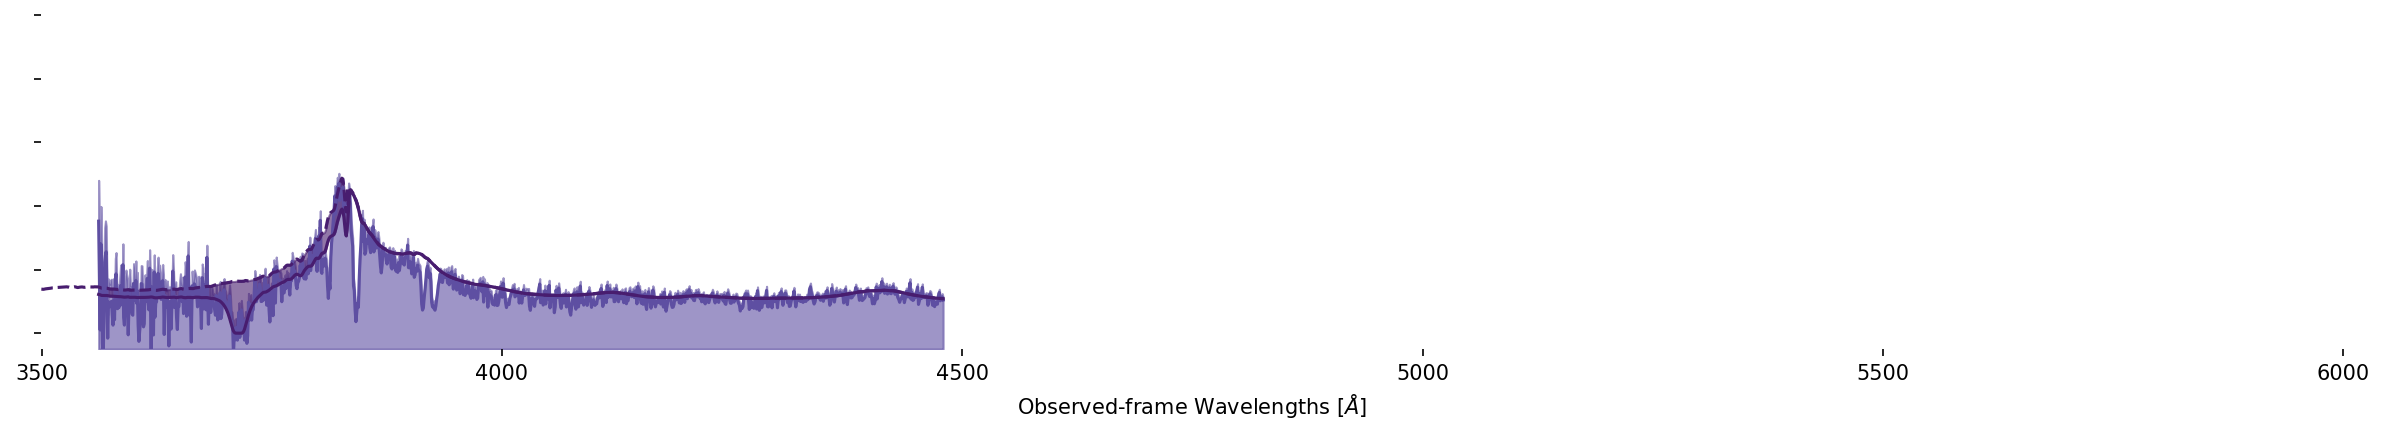

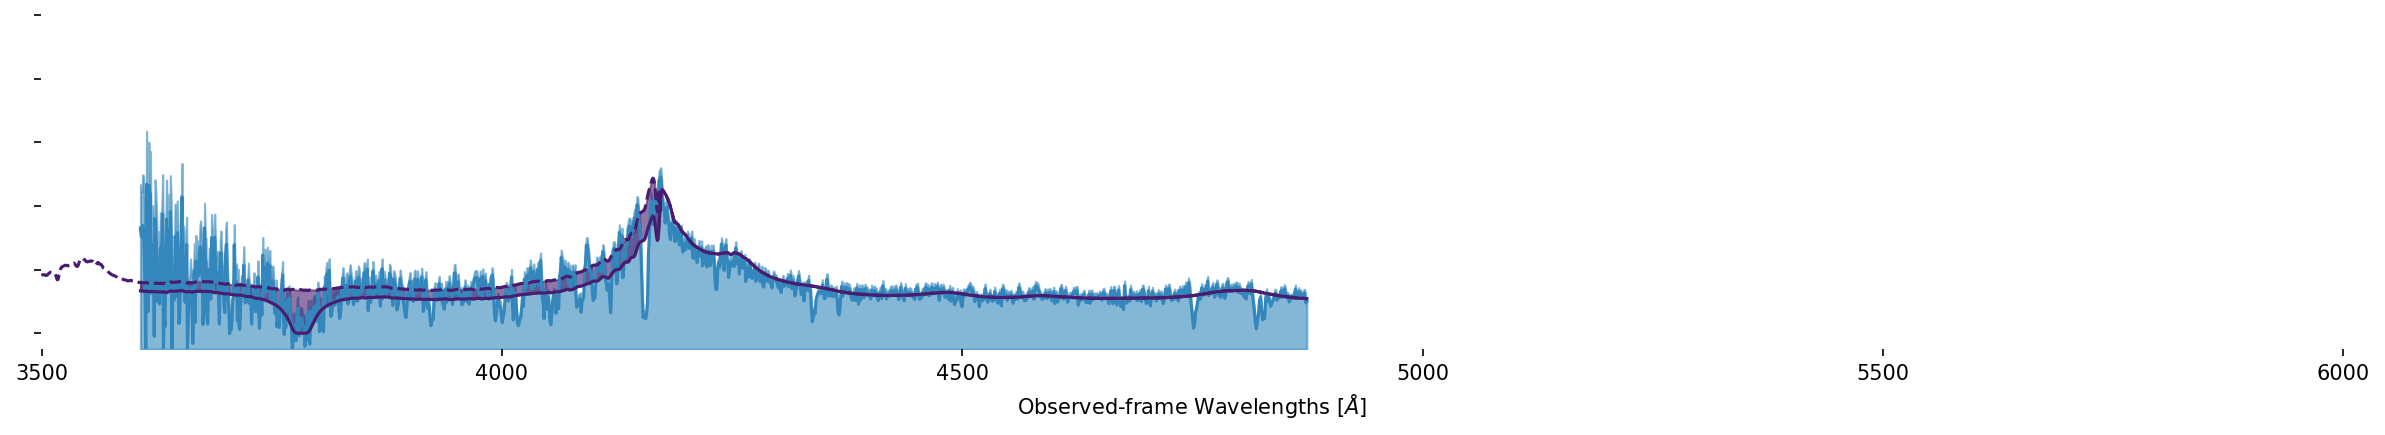

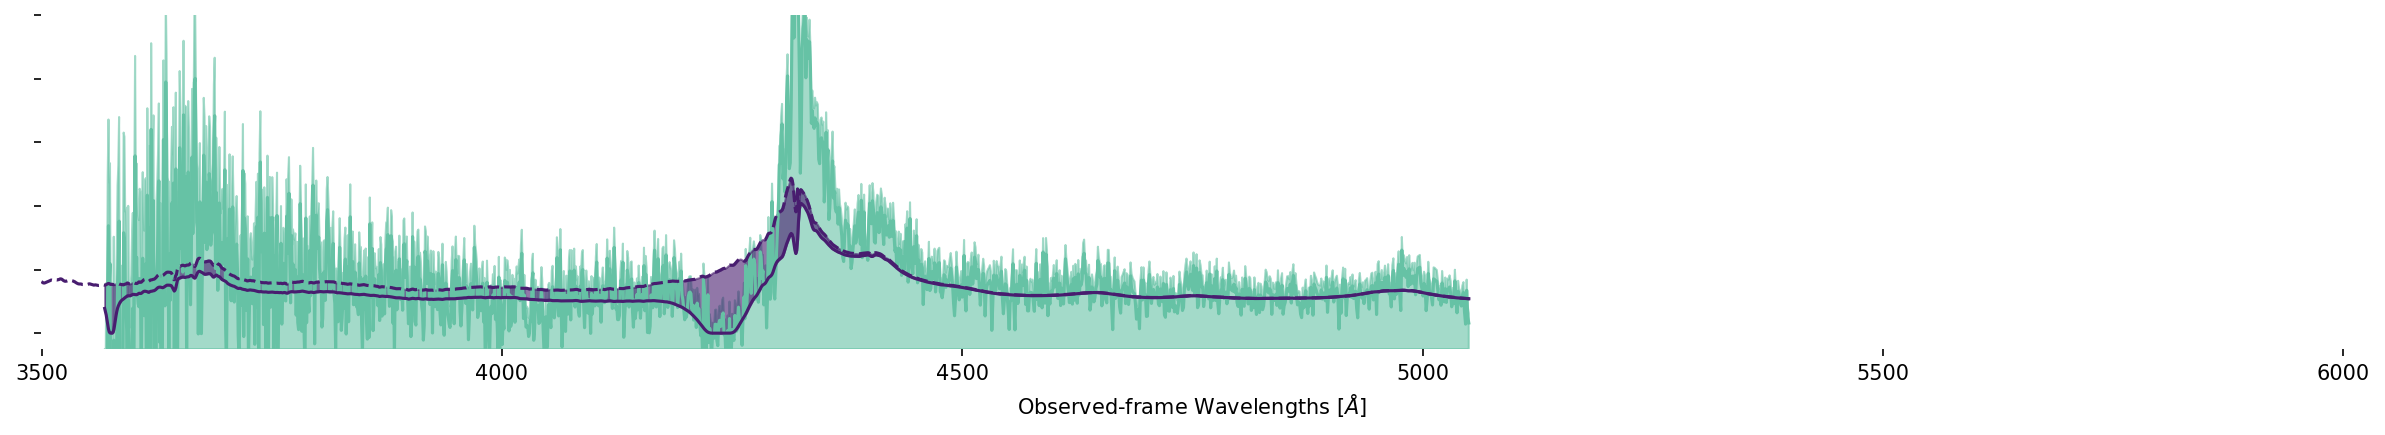

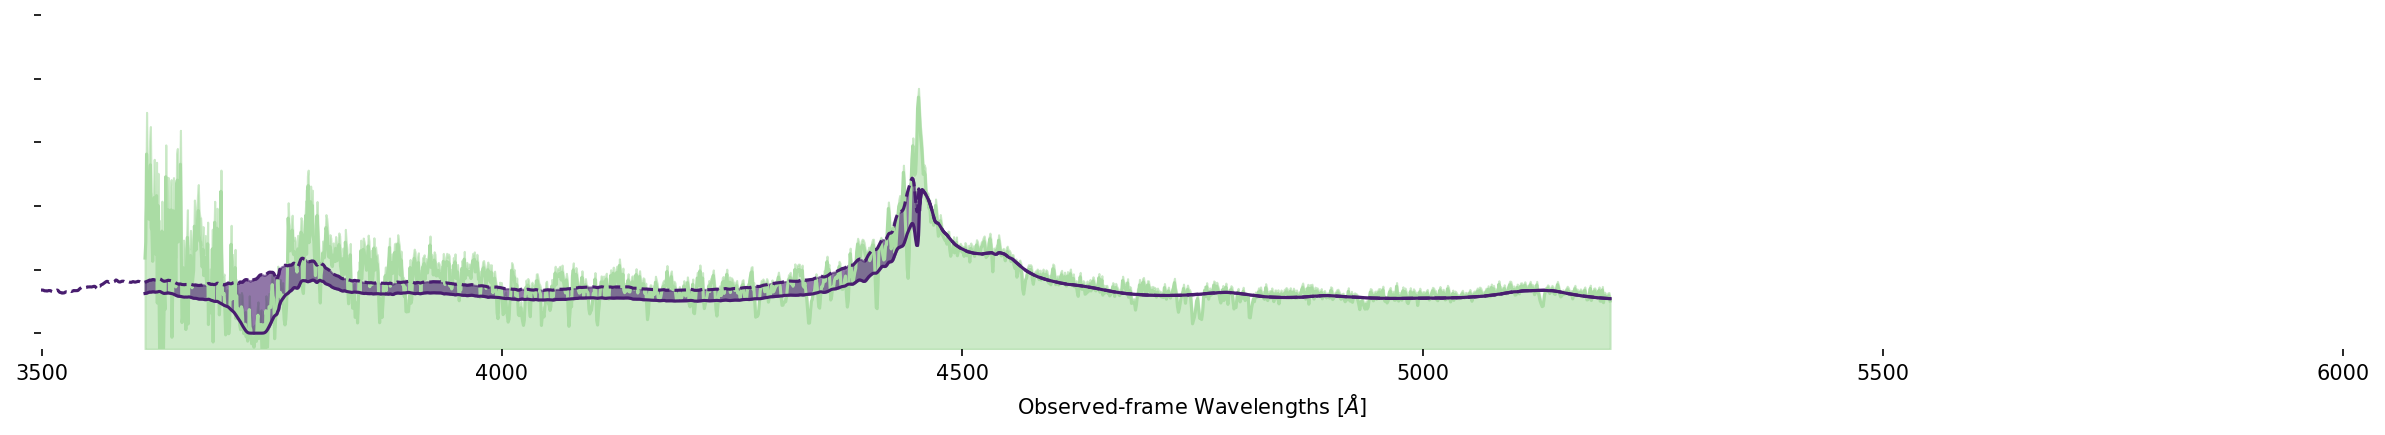

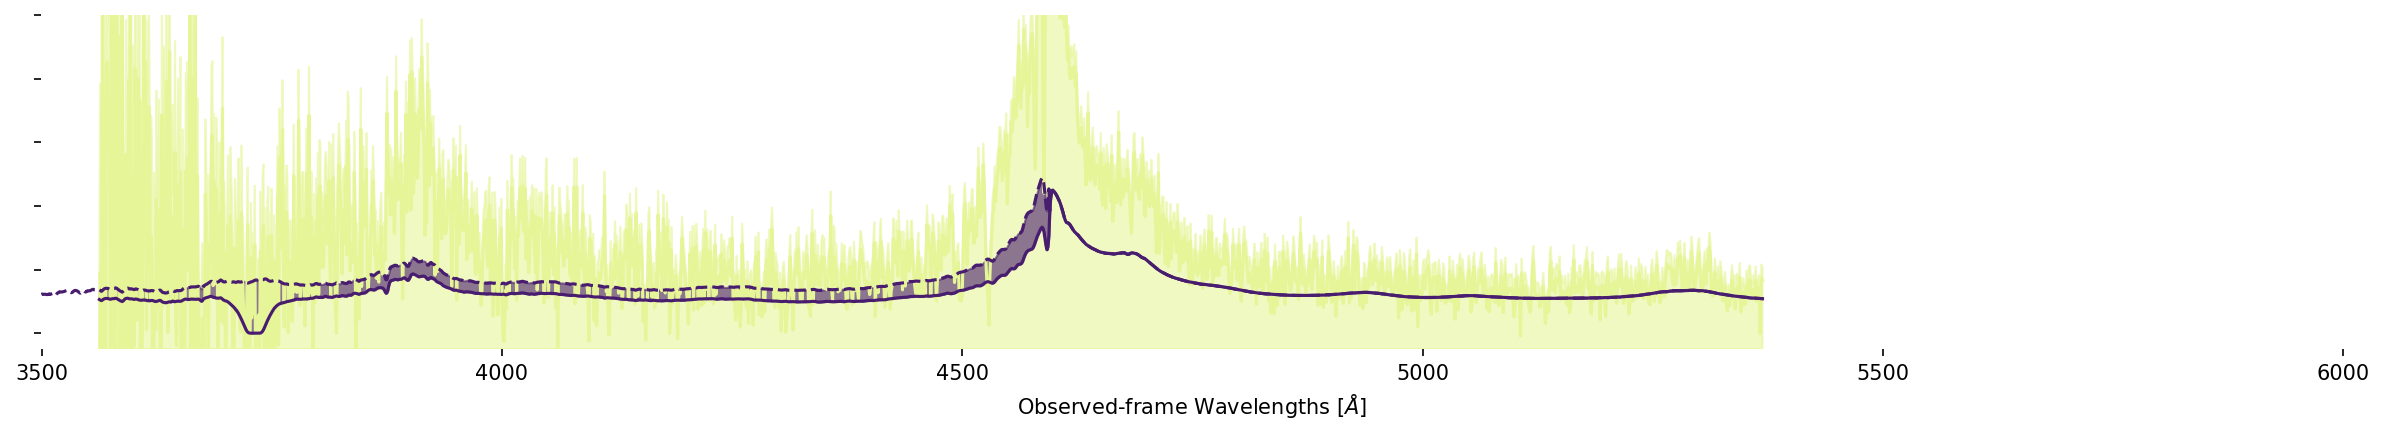

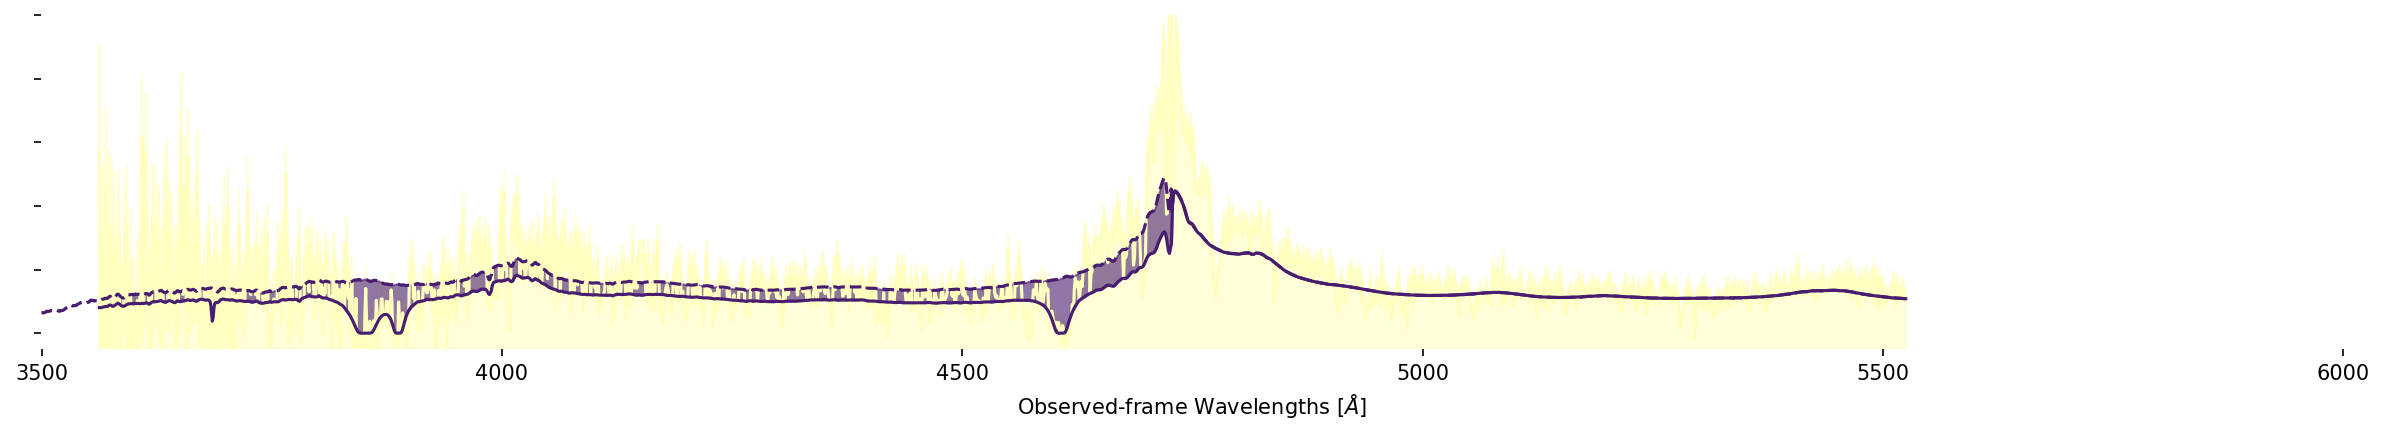

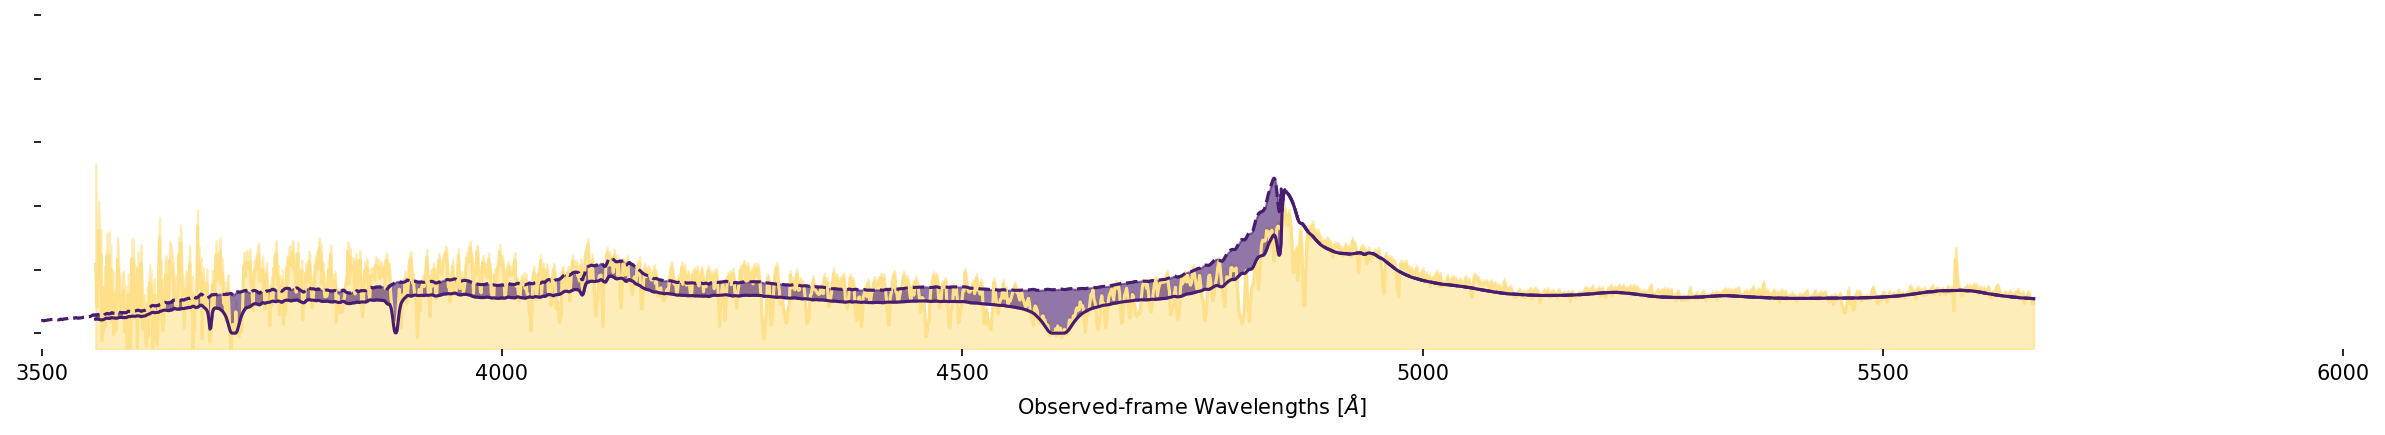

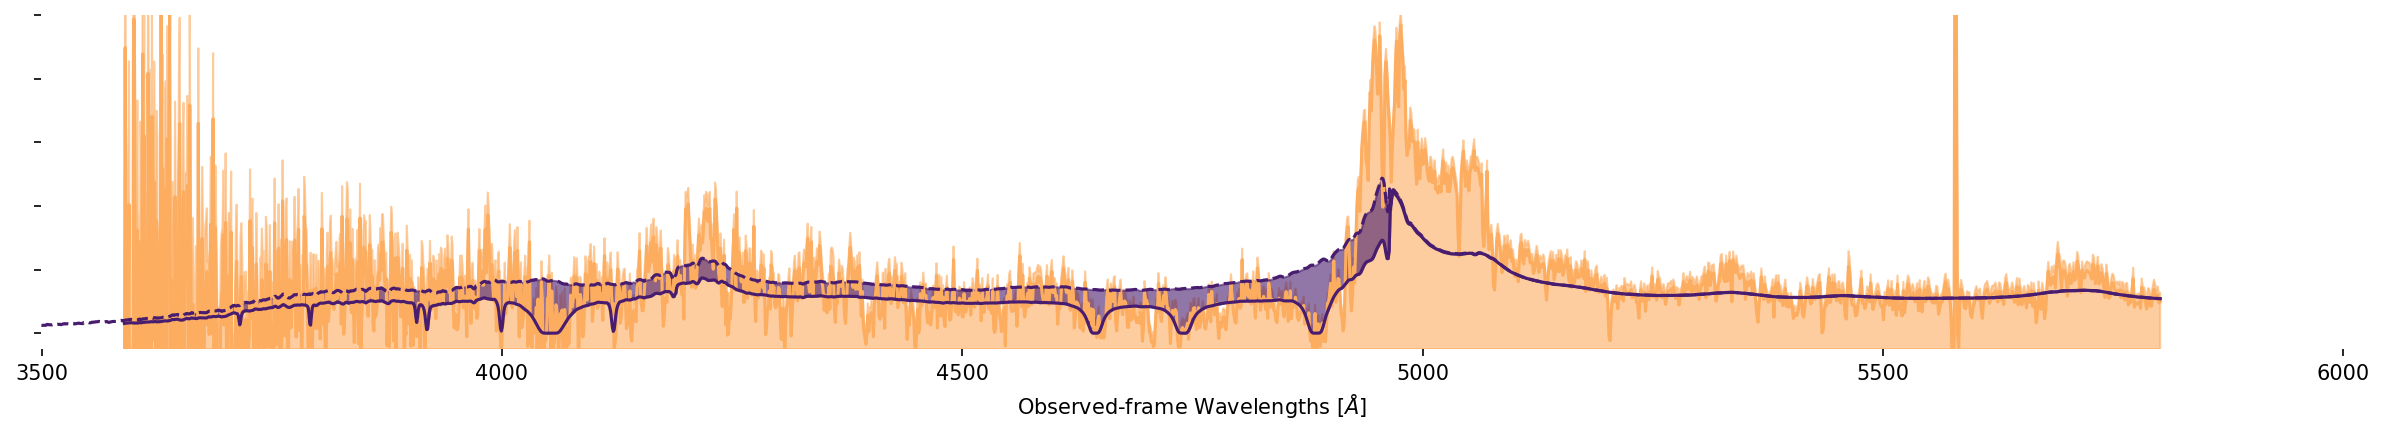

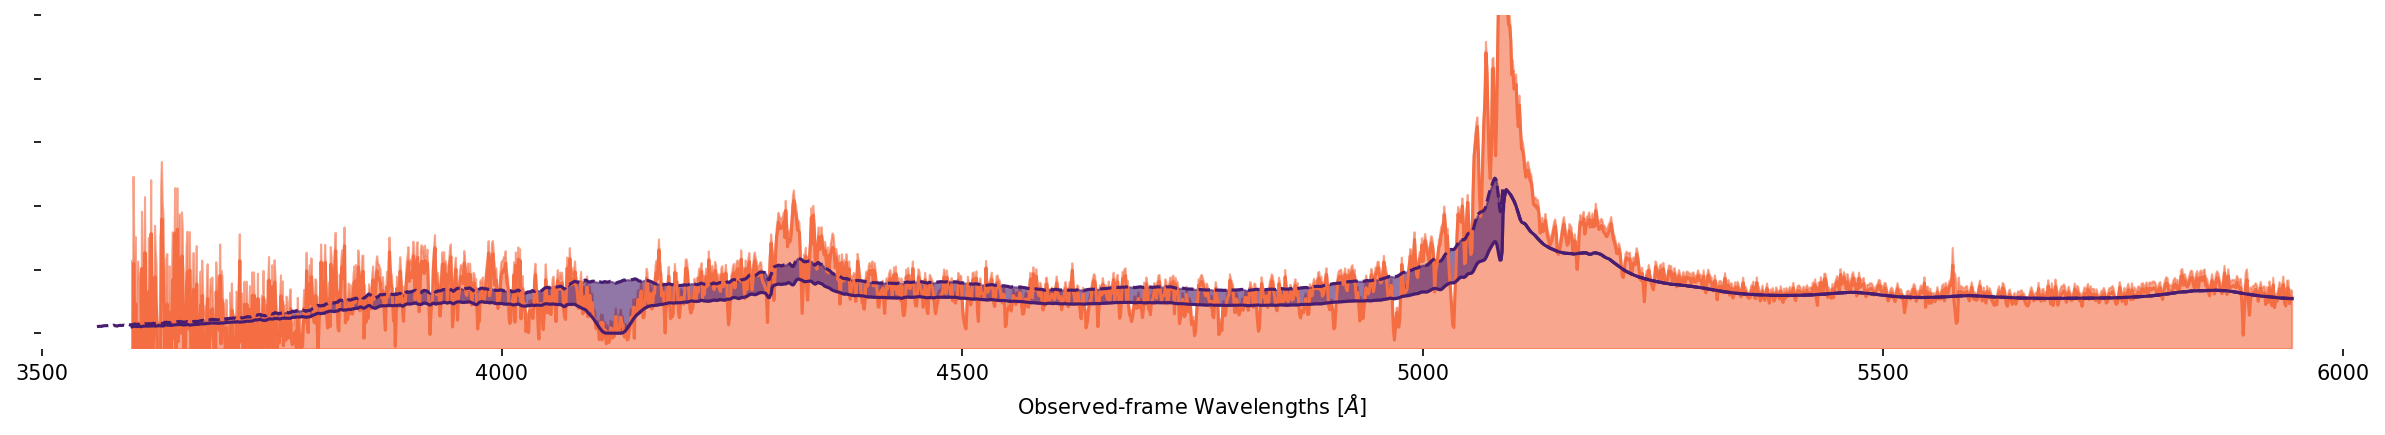

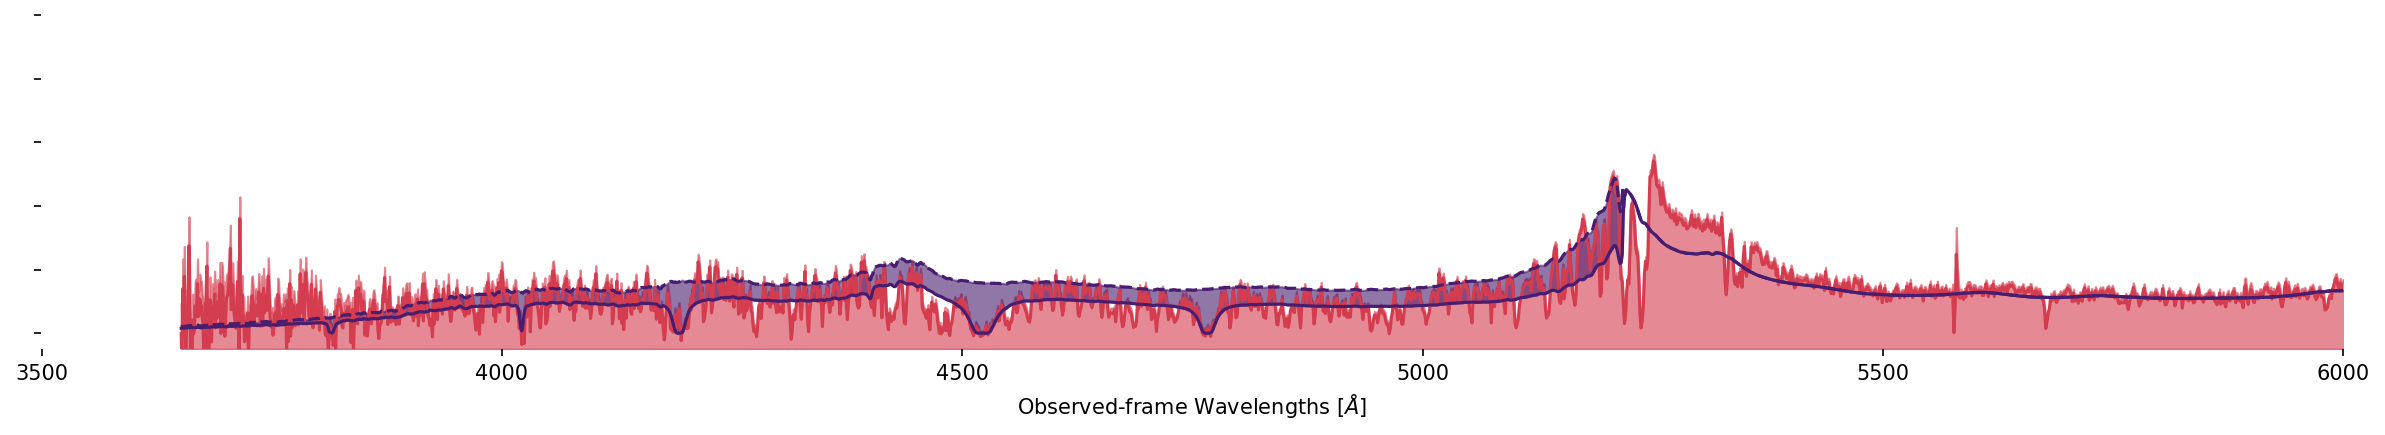

In [121]:
# Now you can get the model with Lya absorbers
spacing = (real_index_zqso_sorted.shape[0]) // 12
ind = np.arange(0, real_index_zqso_sorted.shape[0], spacing)

ind = ind[:10]

for k, ith in enumerate(real_index_zqso_sorted[ind]):
    spec_dict = dr12q_catalog[real_index[ith]]

    # extract info
    plate = spec_dict["plate"]
    mjd = spec_dict["mjd"]
    fiber_id = spec_dict["fiber_id"]

    # read spec
    wavelengths, flux, noise_variance, pixel_mask = download_and_read(
        plate, mjd, fiber_id
    )

    z_qso = spec_dict["z_qso"]
    rest_wavelengths = wavelengths / (1 + z_qso)

    # dla detection
    dlas_dict = spec_dict["dlas"]
    num_dlas = len(dlas_dict)
    z_dlas = []
    log_nhis = []
    for j in range(num_dlas):
        z_dlas.append(dlas_dict[j]["z_dla"])
        log_nhis.append(dlas_dict[j]["log_nhi"])

    # Print out the basic info
    print(spec_dict)

    ################### Plotting the model ###################
    fig, ax = plt.subplots(1, 1, figsize=(16, 3))
    # from blue to red
    redshift_color = cmap(k / len(ind))

    # plotting normalization
    normalization = 0

    # Make the GP model interpolated onto the observed quasar spectum
    gp.set_data(
        rest_wavelengths, flux, noise_variance, pixel_mask, z_qso, build_model=True
    )
    # p( D | z_abs =  z_lya, NHI = nhi, absorber model)
    lya_gp.set_data(
        rest_wavelengths,
        flux,
        noise_variance,
        pixel_mask,
        z_qso,
        build_model=True,
    )
    lya_mu, lya_M, lya_omega2 = lya_gp.this_dla_gp(
        z_dlas, [10**log_nhi for log_nhi in log_nhis]
    )

    # Mean function
    ax.plot(
        gp.X * (1 + z_qso),  # quasar spectrum's rest-frame wavelengths
        gp.Y + normalization,  # quasar spectrum's flux
        label="Data",
        color=redshift_color,
    )
    ax.fill_between(
        gp.X * (1 + z_qso),
        -0.5,
        gp.Y + normalization + np.sqrt(gp.v),
        label="SDSS Instrumental Uncertainty (95%)",
        color=redshift_color,
        alpha=0.6,
    )
    ax.plot(
        gp.rest_wavelengths * (1 + z_qso),
        gp.mu + normalization,
        label="GP null model (mu = continuum)",
        color="C0",
        ls="--",
    )

    # This line plots model
    ax.plot(
        gp.X * (1 + z_qso),
        lya_mu + normalization,
        color="C0",
        label="GP Lya model (mu = meanflux)",
    )  # GP model's mean function
    ax.fill_between(
        gp.X * (1 + z_qso),
        lya_mu + normalization,
        gp.mu_interpolator(gp.X),
        color="C0",
        alpha=0.6,
        label="Absorption",
    )
    # plt.text(gp.X[200] * (1 + z_qso), lya_mu[200] * normalization, "$z_{QSO} = $" + "{:.3g}".format(z_qso))

    ax.set_xlabel("Observed-frame Wavelengths [$\AA$]")
    # ax.set_ylabel("Normalized Flux")
    ax.set_xlim(3500, 6000)
    ax.set_ylim(-0.5, 10)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # ax.axis("off")
    ax.set(yticklabels=[])
    fig.tight_layout()

    fig.savefig("demo_spec_{}.png".format(k), dpi=150, transparent=True)

In [127]:
zqsos = [
    dr12q_catalog[real_index[index]]["z_qso"] for index in real_index_zqso_sorted[ind]
]
zqsos

[2.153,
 2.4312891960144043,
 2.555,
 2.6633598804473877,
 2.779546022415161,
 2.888789176940918,
 2.9871022701263428,
 3.083937168121338,
 3.1847848892211914,
 3.2920472621917725]

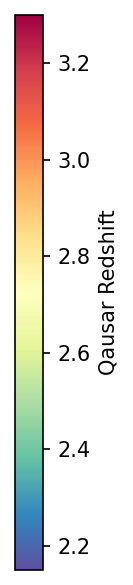

In [149]:
a = np.array([[2.15, 3.3]])

plt.figure(figsize=(2, 4))

img = plt.imshow(a, cmap=cmap)

plt.gca().set_visible(False)
# cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(
    orientation="vertical",
    label="Qausar Redshift",
)
plt.tight_layout()
plt.savefig("colorbar.png", dpi=150, transparent=True)